In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing necessary libraries

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import os
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout
from keras import backend as K
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from google.colab.patches import cv2_imshow
import pandas as pd
from keras import losses
from keras.losses import BinaryCrossentropy

**Reading training and test datasets**

In [3]:
df = pd.read_csv(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_training_data.csv')
df.head(5)

,path,image_id,width,height,KB_size,label
0,C:\Users\Lenovo\Desktop\ML_coursework\project\...,b6fffe_0.jpg,400,400,47.359,CE
1,C:\Users\Lenovo\Desktop\ML_coursework\project\...,set114.jpg,400,400,19.391,LAA
2,C:\Users\Lenovo\Desktop\ML_coursework\project\...,111.jpg,400,400,28.133,LAA
3,C:\Users\Lenovo\Desktop\ML_coursework\project\...,CEset3305.jpg,400,400,25.210,CE
4,C:\Users\Lenovo\Desktop\ML_coursework\project\...,5c92f8_0.jpg,400,400,26.142,CE


In [5]:
df['binary_label'] = np.where(df['label']== 'CE', 0, 1)  #CE is 0, LAA is 1

In [6]:
df.head()

,path,image_id,width,height,KB_size,label,binary_label
0,C:\Users\Lenovo\Desktop\ML_coursework\project\...,b6fffe_0.jpg,400,400,47.359,CE,0
1,C:\Users\Lenovo\Desktop\ML_coursework\project\...,set114.jpg,400,400,19.391,LAA,1
2,C:\Users\Lenovo\Desktop\ML_coursework\project\...,111.jpg,400,400,28.133,LAA,1
3,C:\Users\Lenovo\Desktop\ML_coursework\project\...,CEset3305.jpg,400,400,25.210,CE,0
4,C:\Users\Lenovo\Desktop\ML_coursework\project\...,5c92f8_0.jpg,400,400,26.142,CE,0


In [7]:
testdf = pd.read_csv(r'/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_testing_data.csv')
testdf['binary_label'] = np.where(testdf['label']== 'CE', 0, 1)

testdf.head()

,path,image_id,width,height,KB_size,label,binary_label
0,C:\Users\Lenovo\Desktop\ML_coursework\project\...,set749.jpg,400,400,31.156,LAA,1
1,C:\Users\Lenovo\Desktop\ML_coursework\project\...,126.jpg,400,400,19.723,LAA,1
2,C:\Users\Lenovo\Desktop\ML_coursework\project\...,set419.jpg,400,400,8.236,LAA,1
3,C:\Users\Lenovo\Desktop\ML_coursework\project\...,CEset3209.jpg,400,400,12.101,CE,0
4,C:\Users\Lenovo\Desktop\ML_coursework\project\...,CEset7219.jpg,400,400,22.926,CE,0


**Image Generators**

In [8]:
# Making transformations on the images - data augmentation to train the model

train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(dataframe=df, directory ='/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_train',
                                                    x_col='image_id', y_col='label',
                                                    target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(dataframe = testdf, directory= '/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_test',
                                                  x_col = 'image_id', y_col = 'label',
                                                  target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 2085 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


**Creating VGG16 model**

In [4]:
# Creating the VGG16 architechture with convolutional layers (Conv2D), max pooling layers (MaxPool2D), and fully connected layers (Dense). A total of 16 layers

def VGG16():

  model = Sequential()

  model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding='same', activation='relu'))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
  model.add(Flatten(name='flatten'))
  model.add(Dense(256, activation='relu', name='fc1'))
  model.add(Dense(128, activation='relu', name='fc2'))
  model.add(Dense(1, activation='sigmoid', name='output'))
  

  return model

In [9]:
# Showing the parameters of the built model, with the number of nodes in each layer

model=VGG16()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [10]:
# Loading the weights of the Image Net pretrained model to save time, and only fine-tunning our models last layers.

Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)
Vgg16.load_weights('/content/drive/MyDrive/Machine Learning project/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [ ]:
# Creating a criteria of early stopping to prevent the model from over-training 

es=EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=20)

In [ ]:
# Our model will use Stochastic Gradient Descent with a learning rate of 1e-6 and momentum of 0.9, and the loss function is a binary cross entropy since our target is only two classes

opt = SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=opt, metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [ ]:
# Locking the layers we are not training for the weights to remain the same 

for layer in Vgg16.layers:
  layer.trainable = False

for layer in model.layers:
  print(layer, layer.trainable)

<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc96f294910> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc96f2a6790> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc96f2f1070> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc96f351ee0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc9600823a0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc96f2a6700> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc960027880> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc960027c40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc96002d160> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc960027fd0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc960033100> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc96002d490> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc96003aeb0> False
<keras.layers.poo

In [ ]:
mc = ModelCheckpoint('/content/drive/MyDrive/vgg16_best_model_balanced3.h5', monitor='accuracy', mode='max', save_best_only=True)

In [ ]:
# Training our model 

H = model.fit_generator(train_generator,epochs=50,verbose=1,callbacks=[mc,es]) # validation_data=test_generator

<ipython-input-17-737fd13a0b5f>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator,epochs=50,verbose=1,callbacks=[mc,es]) # validation_data=test_generator


Epoch 1/50
66/66 [==============================] - 390s 6s/step - loss: 2.3123 - accuracy: 0.5223 - auc: 0.5274 - precision: 0.5491 - recall: 0.4959
Epoch 2/50
66/66 [==============================] - 39s 582ms/step - loss: 1.5120 - accuracy: 0.5506 - auc: 0.5713 - precision: 0.5666 - recall: 0.6075
Epoch 3/50
66/66 [==============================] - 38s 576ms/step - loss: 1.1892 - accuracy: 0.5866 - auc: 0.6056 - precision: 0.6080 - recall: 0.5947
Epoch 4/50
66/66 [==============================] - 39s 590ms/step - loss: 1.0597 - accuracy: 0.5871 - auc: 0.6158 - precision: 0.6070 - recall: 0.6020
Epoch 5/50
66/66 [==============================] - 38s 574ms/step - loss: 0.9674 - accuracy: 0.5885 - auc: 0.6198 - precision: 0.6083 - recall: 0.6038
Epoch 6/50
66/66 [==============================] - 39s 589ms/step - loss: 0.8889 - accuracy: 0.6000 - auc: 0.6332 - precision: 0.6251 - recall: 0.5919
Epoch 7/50
66/66 [==============================] - 40s 605ms/step - loss: 0.8335 - accura

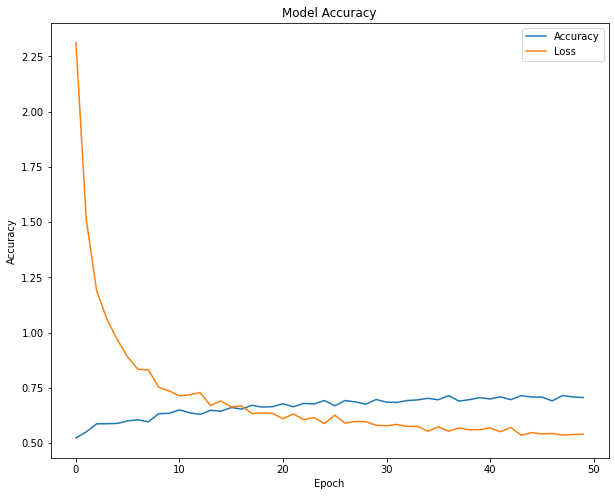

In [ ]:
#plotting the accuracy for test and train

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(H.history['accuracy'])
plt.plot(H.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Loss'])
plt.show()

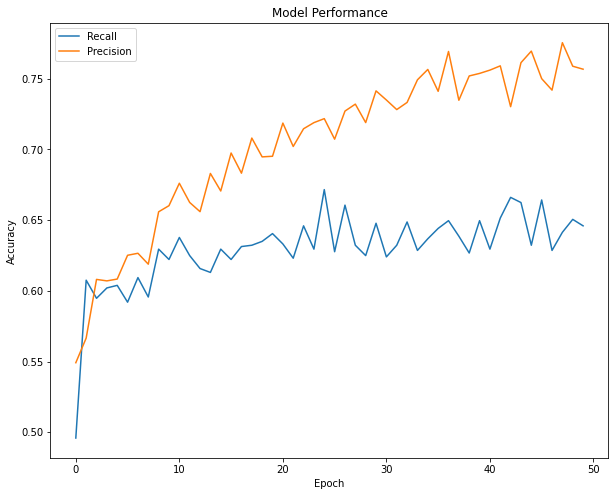

In [ ]:
#plotting the accuracy for test and train

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(H.history['recall'])
plt.plot(H.history['precision'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Recall','Precision'])
plt.show()

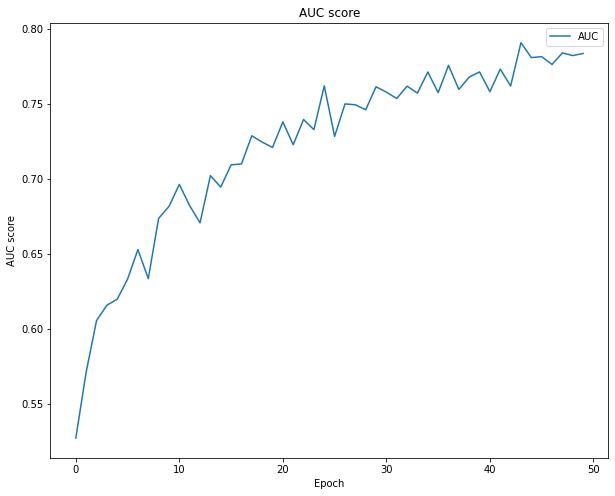

In [ ]:
#plotting the AUC for test and train
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(H.history['auc'])
plt.title('AUC score')
plt.ylabel('AUC score')
plt.xlabel('Epoch')
plt.legend(['AUC'])
plt.show()

### **Metrics for model**

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
model.load_weights('/content/drive/MyDrive/vgg16_best_model_balanced3.h5')

In [13]:
y_test = np.array(testdf['binary_label'])

print(y_test)

[1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1
 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1
 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0
 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1
 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1
 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1
 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1
 0 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0
 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1
 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1
 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1
 1 0 1 0 0 1 1 0 0 1 1 1 

In [14]:
# Creating a list with all the paths for the test images to later read each one of them 

test_path = '/content/drive/MyDrive/Machine Learning project/Balanced_training_set/Balanced/balanced_test/'  # Folder path 

x_test =  np.array(testdf['image_id'])
final_test_path = []

for i in x_test:
  path = test_path + i
  final_test_path.append(path)

In [15]:
#Making predictions for all test images, the returned predictions are probabiblities of the image belonging to the positivie class
from keras.applications.vgg16 import preprocess_input, decode_predictions

y_pred = []

for path in final_test_path:
  img = tf.keras.utils.load_img(path, target_size=(224, 224))
  img_data = tf.keras.utils.img_to_array(img)
  img_data = np.expand_dims(img_data, axis=0)
  img_data = preprocess_input(img_data)
  preds = model.predict(img_data)
  y_pred.append(preds[0][0])

1/1 [==============================] - 0s 15ms/step


In [16]:
# Function to get the predictions on binary format based on treshold and print precision, recall, f1 score, accuracy 
from sklearn.metrics import classification_report, confusion_matrix

def class_report(y_pred, treshold):
  y_pred = np.array(y_pred)
  y_pred_binary = np.where(y_pred > treshold, 1,0)
  print(classification_report(y_test, y_pred_binary))

  return y_pred_binary

In [17]:
# Function to plot a confusion matrix of the test data, with CE = 0 and LAA = 1

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def conf_matrix(y_test, y_pred_binary):
  cm = confusion_matrix(y_test, y_pred_binary)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['CE', 'LAA'])
  fig, ax = plt.subplots(figsize=(8,8))
  disp.plot(ax=ax)
  plt.show()

**Treshold = 0.8**

In [18]:
# CE = 0   LAA = 1
y_pred_binary = class_report(y_pred, 0.8)

              precision    recall  f1-score   support

           0       0.60      0.88      0.71       247
           1       0.81      0.46      0.59       275

    accuracy                           0.66       522
   macro avg       0.70      0.67      0.65       522
weighted avg       0.71      0.66      0.65       522



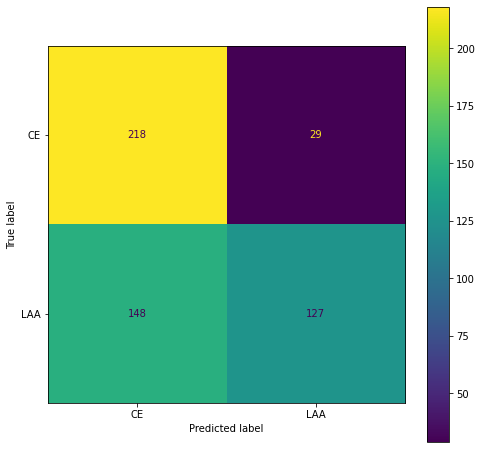

In [19]:
conf_matrix(y_test, y_pred_binary)

**Treshold = 0.65**

In [20]:
y_pred_binary = class_report(y_pred, 0.65)

              precision    recall  f1-score   support

           0       0.62      0.73      0.67       247
           1       0.72      0.60      0.65       275

    accuracy                           0.66       522
   macro avg       0.67      0.67      0.66       522
weighted avg       0.67      0.66      0.66       522



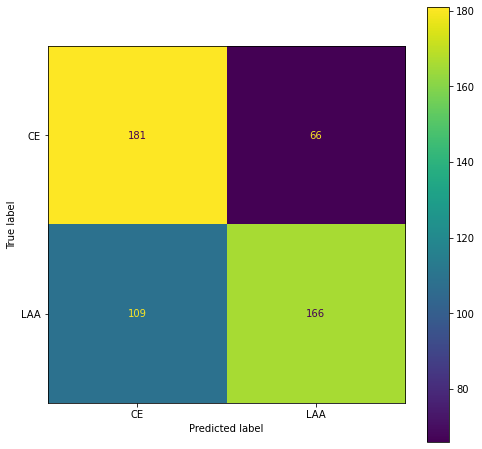

In [21]:
conf_matrix(y_test, y_pred_binary)

**Treshold = 0.5**

In [22]:
y_pred_binary = class_report(y_pred, 0.5)

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       247
           1       0.64      0.71      0.67       275

    accuracy                           0.63       522
   macro avg       0.63      0.63      0.63       522
weighted avg       0.63      0.63      0.63       522



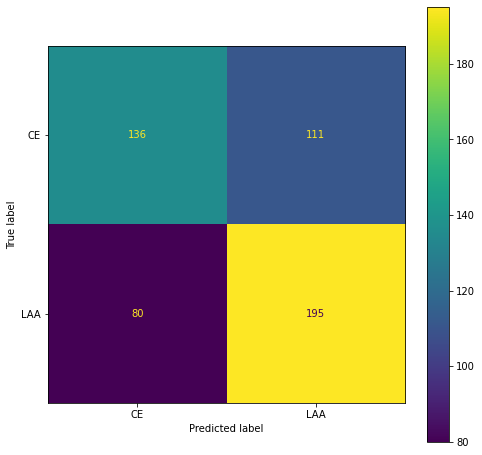

In [23]:
conf_matrix(y_test, y_pred_binary)

**Treshold = 0.3**

In [24]:
y_pred_binary = class_report(y_pred, 0.3)

              precision    recall  f1-score   support

           0       0.60      0.21      0.32       247
           1       0.55      0.87      0.68       275

    accuracy                           0.56       522
   macro avg       0.58      0.54      0.50       522
weighted avg       0.58      0.56      0.51       522



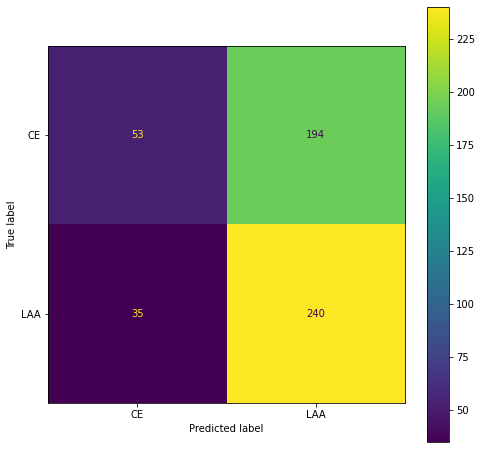

In [25]:
conf_matrix(y_test, y_pred_binary)

**ROC Curve**

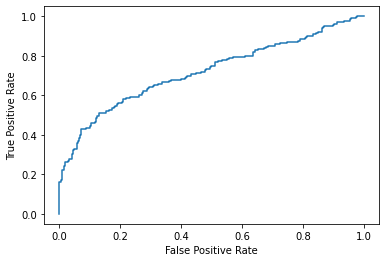

In [26]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [27]:
# Getting the Area Under Curve score

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.7179977916820022


## **Model Evaluation**

In [ ]:
# Test Metrics

results = model.evaluate(x = test_generator, batch_size=32, verbose = 1, return_dict = True)

17/17 [==============================] - 5s 253ms/step - loss: 0.6154 - accuracy: 0.6667 - auc: 0.7154 - precision: 0.7563 - recall: 0.5418
